<a href="https://colab.research.google.com/github/HannaKi/DL_HLT_2020_groupwork/blob/master/DLHLT_2020_Group2_HK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning in Human Language Technologies 2020
# Text classification project

#### Group 2: Hanna Kitti, Dang Trinh Ha, Timo Jokela

Contributions:

xxxx

## Preparations

### Imports

In [1]:
!pip install transformers

In [2]:
!pip install scikit-multilearn

In [3]:
import io
import json
import numpy as np
import os
import pandas as pd
import pprint
import pickle
import seaborn as sns
import torch
import transformers

from functools import partial
from matplotlib import pyplot as plt
from pathlib import Path
#from pytorch_pretrained_bert import BertTokenizer, BertConfig
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange

%matplotlib inline
pp = pprint.PrettyPrinter(indent=4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Dataset

Data split

- Training set: used for training the models
- Validation (or model assessment) set: when comparing
different models trained on training set, select one with lowest
error on validation set
- Test set: test the final hypothesis on test set to get unbiased
error estimate for it

After error estimation the final model is often trained on
combined training, validation and test set, using best
hyperparameters found during model selection
- Complication: randomized optimization approaches where
different runs with same hyperparameters can lead to very
different quality solutions (e.g. neural network)

In [4]:
# HK
# Download development data
!wget http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-dev.tsv
# Download test data
!wget http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-test.tsv
# Download train data
!wget http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-train.tsv



--2020-05-11 18:47:02--  http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-dev.tsv
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4035578 (3.8M) [application/octet-stream]
Saving to: ‘fincore-dev.tsv.3’

fincore-dev.tsv.3   100%[===================>]   3.85M  1.67MB/s    in 2.3s    

2020-05-11 18:47:05 (1.67 MB/s) - ‘fincore-dev.tsv.3’ saved [4035578/4035578]

--2020-05-11 18:47:08--  http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-test.tsv
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8512687 (8.1M) [application/octet-stream]
Saving to: ‘fincore-test.tsv.3’

fincore-test.tsv.3  100%[===================>]   8.12M  2.82MB/s    in 2.9s    

2020-05-11 18:47:11 (2.

In [0]:
orig_columns = ['reg', 'text']

# load the data
df_train = pd.read_csv('fincore-train.tsv', sep='\t', names=orig_columns)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

df_dev_full = pd.read_csv('fincore-dev.tsv', sep='\t', names=orig_columns)
df_dev_full = (df_dev_full.sample(frac=1, random_state=42)
                          .reset_index(drop=True))

df_test_full = pd.read_csv('fincore-test.tsv', sep='\t', names=orig_columns)
df_test_full = (df_test_full.sample(frac=1, random_state=42)
                            .reset_index(drop=True))

The following classes of the test and development sets are not in the training set:

In [6]:
print("Dev/test classes not in the training set:\n")
print(df_test_full[~df_test_full.reg.isin(df_train.reg.unique())].reg.unique())
print(df_dev_full[~df_dev_full.reg.isin(df_train.reg.unique())].reg.unique())

Dev/test classes not in the training set:

['FC NA DP IN ' 'FC NA DT IN ' 'SL LY ' 'HI  IP IG ' 'IB IN IN  '
 'RE HI PB NA ' 'IT SP DT IN ' 'RV OP PB NA ' 'IP IG NE NA '
 'NE NA DT IN ' 'CB NA EB IG ' 'OA NA FC NA ' 'DS IG AV OP ']
['ID  PB NA ' 'DS IG MT OS ' 'DF ID NE NA ' 'OP  DP IN ' 'DF ID PB NA '
 'TB NA CB NA ']


Since we can not train the model to predict labels it has not seen during training phase, we will keep only rows in dev and test data which have the labels that appear also in training data:

In [0]:
df_test = df_test_full[
    df_test_full.reg.isin(df_train.reg.unique())].reset_index(drop=True)
df_dev = df_dev_full[
    df_dev_full.reg.isin(df_train.reg.unique())].reset_index(drop=True)

Texts for all the datasets:

In [0]:
txt_train = [x for x in df_train.text]
txt_dev = [x for x in df_dev.text]
txt_test = [x for x in df_test.text]

Encoded labels (registers):

In [0]:
# labels as numbers
label_encoder = LabelEncoder()
train_classes = label_encoder.fit_transform(df_train.reg)
dev_classes = label_encoder.transform(df_dev.reg)
test_classes = label_encoder.transform(df_test.reg)
num_classes = len(label_encoder.classes_)

#### Some initial thoughts

We draw a chart for visualizing the distribution of different kinds of classes.

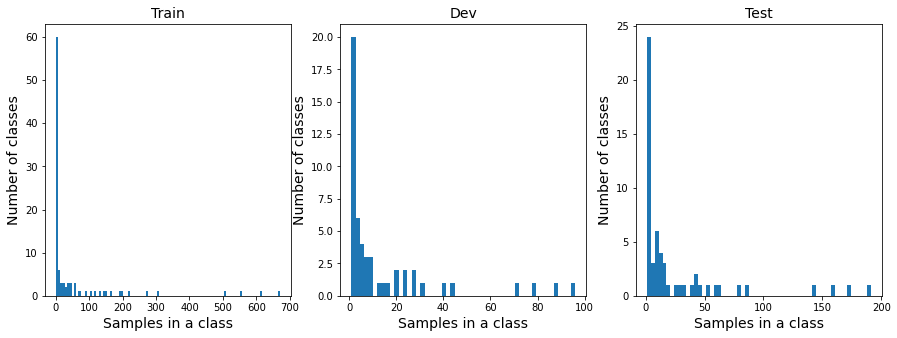

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (df, name) in enumerate(zip([df_train, df_dev, df_test],
                                   ['Train', 'Dev', 'Test'])):
    ax[i].hist(df.reg.value_counts().values, bins=len(df.reg.unique()))
    ax[i].set_title(name, fontsize=14)
    ax[i].set_xlabel("Samples in a class", fontsize=14)
    ax[i].set_ylabel("Number of classes", fontsize=14)
plt.show()

We immediately observe that the number of classes with just one sample is very high, whereas there are lot less classes that have several representatives. That is, the distribution of labels is highly skewed in all the data sets. This could be fixed with data augmentation but since we have no experience, we settle for the data provided. Also further manual annotation to gain more data would probably improve model performance in all the upcoming classifiers.

Especially predicting the labels which have only a few instances in the data will be a challenging task for the classifiers since they might not be able to truly learn the characteristics of the label by one or two instances.

Small classes (labels) also hinder using powerful hyperparameter optimizers, such as GridSearch, in optimal way: Stratification for K-folds in inner and outer loops is impossible because of the scarcity of the instances in the smallest classes.

## Milestone 1

For the first two models we construct vocabularies of alternative sizes:

In [28]:
print("Generating vocabularies...")
max_features_options = [1000, 10000, 20000, 30000, 40000, 50000]
ms1_vocabs = {}
for mf in max_features_options:
    # a vectorizer and the feature matrices for this particular max_features
    # NOTE: outside of this notebook other params were tested; see baseline
    vectorizer = CountVectorizer(max_features=mf,
                                 binary=False,
                                 ngram_range=(1, 1))
    ms1_vocabs[mf] = {
        'vectorizer': vectorizer,
        'train_fm': vectorizer.fit_transform(txt_train),
        'dev_fm': vectorizer.transform(txt_dev),
        'test_fm':  vectorizer.transform(txt_test)
    }
print("Done.")

Generating vocabularies...
Done.


### 1.0: Baseline (Naive Bayes)

Naive Bayes classifier to be used as a baseline. It is trained on the training data for each separate dataset (different _max_features_ params for the CountVectorizer). Additionally accuracy on the permutated test sets are computed for the purpose of ensuring that performance with actual data differs from performance with junk data.

In [29]:
def mnb_compute(X, y, mnb):
    predictions = mnb.predict(X)
    return (np.sum(predictions == y) / len(y), predictions)

bayes_results = {}
print("Computing stats for the MNB models...")
for max_feats, vocab in ms1_vocabs.items():
    # train using the training set
    mnb = MultinomialNB()
    mnb.fit(vocab['train_fm'], df_train.reg)

    # the accuracy of the trained model on all the sets
    train_accuracy, _ = mnb_compute(vocab['train_fm'], df_train.reg, mnb)
    dev_accuracy, _ = mnb_compute(vocab['dev_fm'], df_dev.reg, mnb)
    test_accuracy, test_preds = mnb_compute(vocab['test_fm'], df_test.reg, mnb)
    
    # accuracy on permutated test set
    permutated = np.random.permutation(df_test.reg)
    perm_accuracy, _ = mnb_compute(vocab['test_fm'], permutated, mnb)
    
    bayes_results[max_feats] = {
        'train_accuracy': train_accuracy,
        'dev_accuracy': dev_accuracy,
        'test_accuracy': test_accuracy,
        'test_predictions': test_preds,
        'perm_accuracy': perm_accuracy,
    }
print("Done.")

Computing stats for the MNB models...
Done.


In [30]:
for mf, stats in bayes_results.items():
    print(f"\nMax features: {mf}\nACCURACY: "
          f"Train {stats['train_accuracy']:.2f}  "
          f"Dev {stats['dev_accuracy']:.2f}  "
          f"Test {stats['test_accuracy']:.2f}  "
          f"Permutated {stats['perm_accuracy']:.2f}  ")



Max features: 1000
ACCURACY: Train 0.60  Dev 0.47  Test 0.47  Permutated 0.07  

Max features: 10000
ACCURACY: Train 0.77  Dev 0.56  Test 0.53  Permutated 0.07  

Max features: 20000
ACCURACY: Train 0.79  Dev 0.56  Test 0.54  Permutated 0.08  

Max features: 30000
ACCURACY: Train 0.80  Dev 0.56  Test 0.54  Permutated 0.08  

Max features: 40000
ACCURACY: Train 0.80  Dev 0.55  Test 0.54  Permutated 0.08  

Max features: 50000
ACCURACY: Train 0.79  Dev 0.54  Test 0.53  Permutated 0.09  


**NOTE**: Outside of this notebook other params (*binary, ngram*) for the CountVectorizer were also tested. Neither here nor with the BOW model had they any practical effect whatsoever. Also, the value of the *max_features* parameter seems to be the most effective approximately in the range of 20 - 40 k, after which the accuracy begins to slowly degrade (possibly due to more features contributing only noise). 

**Having several different models for different parameter sets proved to be very demanding RAM-wise (particularly for BOW)**, and therefore, to keep the hardware requirements in check, we reduced the number of different *max_feature*s values to three:

In [0]:
%%capture
# limit the number of different max_features params
max_features_options = [1000, 10000, 30000]
ms1_vocabs.pop(20000)
ms1_vocabs.pop(40000)
ms1_vocabs.pop(50000)

### 1.1: BOW

We tried several optimizers, of which SGD and Adam seemed to be the most effective. Therefore we decided to cover only them in this notebook:

In [0]:
keras_optimizers = {
    'SGD': optimizers.SGD,
    'Adam': optimizers.Adam,
}

Next we define the function responsible for building the bow model.


**NOTE**: Outside of this notebook several alternative model constructions were tested. These included other forms of regularization (e.g. dropout), different setups for hidden layer(s) and using pre-computed weights due to the data being imbalanced. None of these had any practical effect.

In [0]:
def build_bow_model(
        feature_matrix, activation=None, optimizer=None, learning_rate=None
    ):
    """ Builds the BOW model according to the parameters """
    doc_count, feature_count = feature_matrix.shape
    inp = Input(shape=(feature_count,))
    hidden = Dense(250, activation=activation)(inp)
    output = Dense(num_classes, activation="softmax")(hidden)
    model = Model(inputs=[inp], outputs=[output])
    optimizer = optimizer(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

We also performed GridSearchCV for the following parameter combinations:
- max_features: 1000, 10000, 30000
- optimizers: SGD, Adam
- activation: tanh, ReLU
- learning rate:  0.00098, 0.00310, 0.00984, 0.03125, 0.09921, 0.31498, 1.0


**NOTE**: This is an extremely taxing process both time- and resource-wise (allocating in total 20 GB of RAM + some swap on the side). Therefore we do not repeat the full computation here, but only list some of the best results, with which we will proceed. Change *DO_BOW_GSCV* to **True** to run the full operation.

Given the availability of sufficient resources, it would also be an option to optimize several other factors (not necessarily using GridSearchCV if not applicable but by other means) such as hidden layer composition or dropout rate (if used). However, due to limited time and hardware we have to settle for the options mentioned above.

In [34]:
!wget https://github.com/HannaKi/DL_HLT_2020_groupwork/blob/master/bow_grid_results.p?raw=true

--2020-05-11 17:51:25--  https://github.com/HannaKi/DL_HLT_2020_groupwork/blob/master/bow_grid_results.p?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/HannaKi/DL_HLT_2020_groupwork/raw/master/bow_grid_results.p [following]
--2020-05-11 17:51:26--  https://github.com/HannaKi/DL_HLT_2020_groupwork/raw/master/bow_grid_results.p
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HannaKi/DL_HLT_2020_groupwork/master/bow_grid_results.p [following]
--2020-05-11 17:51:26--  https://raw.githubusercontent.com/HannaKi/DL_HLT_2020_groupwork/master/bow_grid_results.p
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

In [0]:
# set to True to perform GridSearchCV again
DO_BOW_GSCV = False

In [0]:
if DO_BOW_GSCV:
    mc = ModelCheckpoint(filepath='/tmp/bow_model.h5',
                         monitor='accuracy',
                         verbose=0,
                         save_best_only=True,
                         mode='auto')

    es = EarlyStopping(monitor='accuracy',
                       patience=20,
                       verbose=0,
                       restore_best_weights=True)

    bow_grid_params = {
        'activation': ['tanh', 'relu'],
        'optimizer': list(keras_optimizers.values()), 
        'learning_rate': np.logspace(-10, 0, num = 7, base = 2).tolist()
    }
    grid_results = {}
    for mf in max_features_options:
        print(f"BOW: GridSearchCV for param max_features={mf}")
        feature_matrix = ms1_vocabs[mf]['train_fm']

        def f(activation=None, optimizer=None, learning_rate=None):
            return build_bow_model(
                feature_matrix,
                activation=activation, 
                optimizer=optimizer,
                learning_rate=learning_rate
            )

        grid = GridSearchCV(
            estimator=KerasClassifier(
                build_fn=f, epochs=40, batch_size=32, verbose=0),
            param_grid=bow_grid_params,
            n_jobs=1,
            cv=3,
            verbose=0,
        )
        grid_results[mf] = grid.fit(
            feature_matrix.toarray(), train_classes, callbacks=[es, mc])
    print("Done.")

    bow_grid_results = {}
    for mf in max_features_options:
        res = grid_results[mf]
        bow_grid_results[mf] = {
            'params': res.cv_results_['params'],
            'rank_test_score': res.cv_results_['rank_test_score'],
            'mean_test_score': res.cv_results_['mean_test_score']
        }
    pickle.dump(bow_grid_results, open('bow_grid_results.p', 'wb'))
else:
    bow_grid_results = pickle.load(open('bow_grid_results.p', 'rb'))
    print("BOW: Loaded GridSearchCV results from a file.")

BOW: Loaded GridSearchCV results from a file.


The following parameter sets ranked the best:

In [0]:
bow_params = {}  # For storing the best models for final comparison
for mf in max_features_options:
    print(f"\n{'--' * 10}\nBest for max_features={mf}:")
    res = bow_grid_results[mf]
    rank = list(res['rank_test_score'])
    idx_best = [rank.index(x) for x in range(1, 4)]
    best = [res['params'][x] for x in idx_best]
    bow_params[mf] = best
    scores = [res['mean_test_score'][x] for x in idx_best]
    for i, r in enumerate(best):
        print(f"\n{['First:', 'Second:', 'Third:'][i]} (score {scores[i]:.3f})\n")
        pp.pprint(r)


--------------------
Best for max_features=1000:

First: (score 0.484)

{   'activation': 'tanh',
    'learning_rate': 0.0098431332023037,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>}

Second: (score 0.471)

{   'activation': 'relu',
    'learning_rate': 0.0098431332023037,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>}

Third: (score 0.465)

{   'activation': 'tanh',
    'learning_rate': 0.03125,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>}

--------------------
Best for max_features=10000:

First: (score 0.538)

{   'activation': 'tanh',
    'learning_rate': 0.0009765625,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}

Second: (score 0.537)

{   'activation': 'tanh',
    'learning_rate': 0.0031003926796253885,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}

Third: (score 0.528)

{   'activation': 'tanh',
    

As can be seen, *tanh* does consistently better than *ReLU*, at least in the context of GridSearchCV. As for the other params, the results are more varied, even though the scores between the parameter sets do not vary considerably. In any case, a line has to be drawn somewhere, and therefore we will perform the full training cycle only with the param sets defined above.

In addition, for regularization purposes, early stopping will be utilized.

In [0]:
# Early Stopping settings
mc = ModelCheckpoint(filepath='/tmp/bow_model.h5',
                     monitor='val_accuracy',
                     verbose=0,
                     save_best_only=True,
                     mode='auto')

es = EarlyStopping(monitor='val_accuracy',
                   patience=20,
                   verbose=0,
                   restore_best_weights=True)

# The parameters that are used in the training process
fit_params = {
    'batch_size': 32,
    'verbose': 0,
    'epochs': 100,
    'callbacks': [mc, es],
}

def train_bow_model(max_features, params, train_classes=train_classes):
    """ Returns a trained BOW model and results for the given parameters """
    
    # Get the correct vocabulary and define the validation set
    vocab = ms1_vocabs[max_features]
    fit_params['validation_data'] = (vocab['dev_fm'], dev_classes)
    
    # Build and train the model
    model = build_bow_model(vocab['train_fm'], **params)
    hist = model.fit(vocab['train_fm'].toarray(), train_classes, **fit_params)

    # compute predictions for all the sets
    train_preds = np.argmax(model.predict(vocab['train_fm'].toarray()), axis=1)
    train_acc = np.sum(np.equal(train_classes, train_preds)) / len(train_classes)
    
    dev_preds = np.argmax(model.predict(vocab['dev_fm'].toarray()), axis=1)
    dev_acc = np.sum(np.equal(dev_classes, dev_preds)) / len(dev_classes)
    
    test_preds = np.argmax(model.predict(vocab['test_fm'].toarray()), axis=1)
    test_acc = np.sum(np.equal(test_classes, test_preds)) / len(test_classes)
    
    return {
        'hist': hist.history,
        'optimizer': params['optimizer'].__name__,
        'learning_rate': params['learning_rate'],
        'train_accuracy': train_acc,
        'validation_accuracy': dev_acc,
        'test_accuracy': test_acc,
        'test_predictions': test_preds
    }
    
bow_results = {}
for mf in max_features_options:
    bow_results[mf] = []
    print(f"\nTraining BOW for max_features={mf}")
    for i, param_set in enumerate(bow_params[mf]):
        print(f"Param set {i + 1}.", end=" ")
        bow_results[mf].append(train_bow_model(mf, param_set))
print("\nDone.")


Training BOW for max_features=1000
Param set 1. Param set 2. Param set 3. 
Training BOW for max_features=10000
Param set 1. Param set 2. Param set 3. 
Training BOW for max_features=30000
Param set 1. Param set 2. Param set 3. 
Done.


Then it's time for some results:

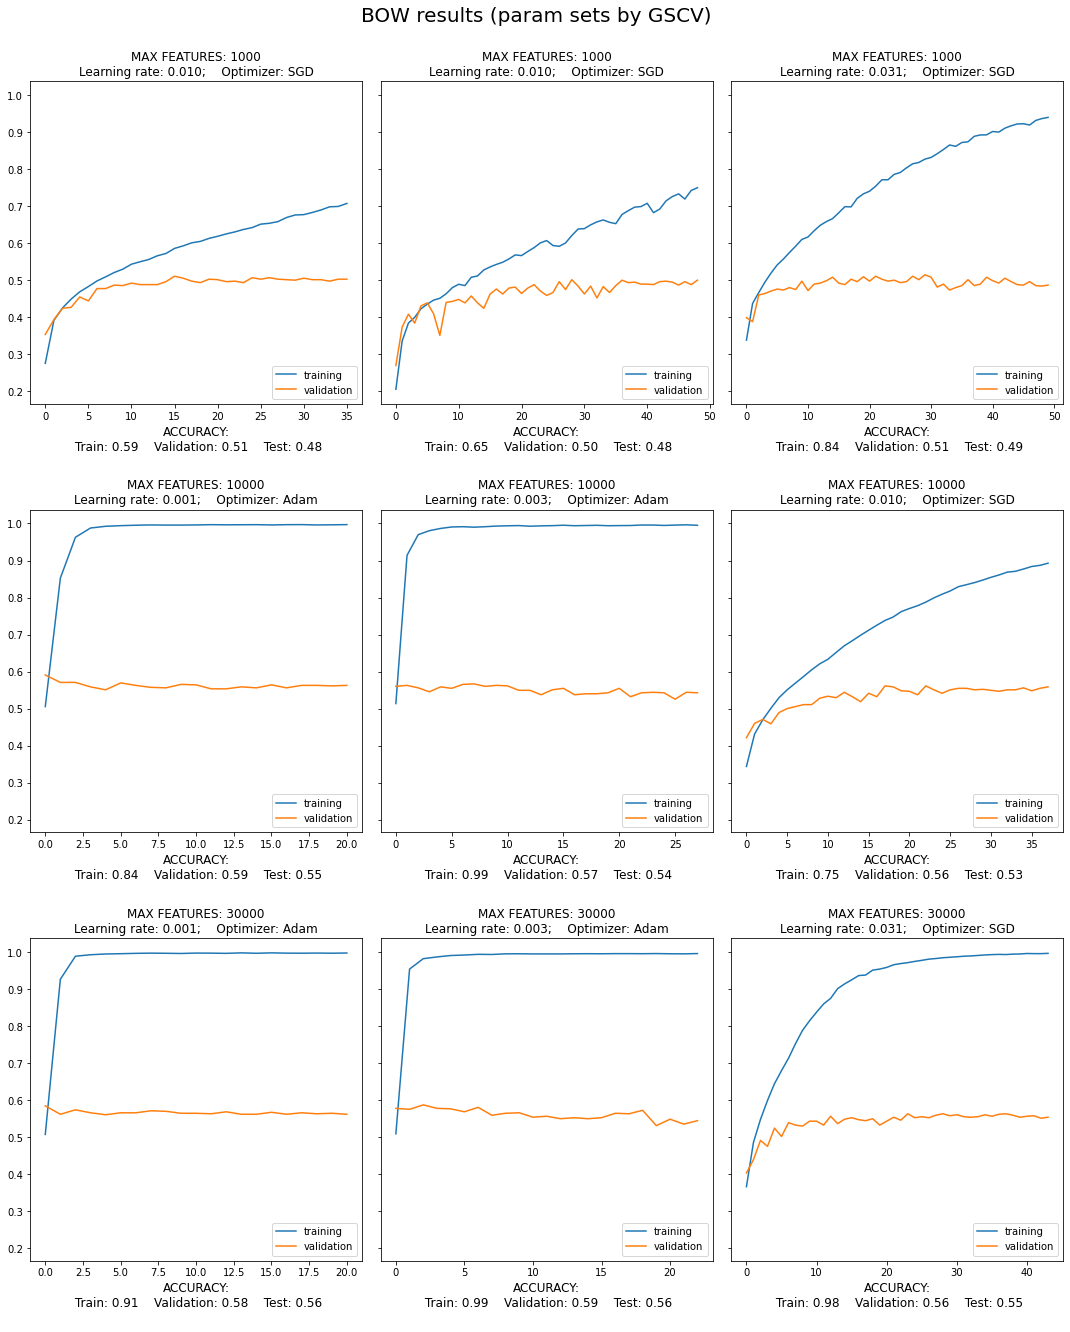

In [0]:
fig, ax = plt.subplots(3, 3, figsize=(15, 18), sharey=True, tight_layout=True)
plt.suptitle("BOW results (param sets by GSCV)\n\n", va='baseline', fontsize=20)
for i, (mf, res_mf) in enumerate(bow_results.items()):
    for j, res in enumerate(res_mf):
        hist = res['hist']
        ax[i][j].set_title(f"MAX FEATURES: {mf}\n"
                        f"Learning rate: {res['learning_rate']:.3f};    "
                        f"Optimizer: {res['optimizer']}",
                        fontsize=12)
        ax[i][j].plot(hist['accuracy'], label='training')
        ax[i][j].plot(hist['val_accuracy'], label='validation')
        ax[i][j].set_xlabel(
            f"ACCURACY:\n Train: {res['train_accuracy']:.2f}    "
            f"Validation: {res['validation_accuracy']:.2f}    "
            f"Test: {res['test_accuracy']:.2f}\n",
            fontsize=12
        )
        ax[i][j].legend(loc='lower right')
plt.show()

As can be seen the results are downright lackluster. Optimizer-wise models with *Adam* do not seem to learn anything at all (or they learn everything they can during the first epoch). The exact value of *max_features* also seems to be somewhat irrelevant as long as it is within reasonable limits.

It should also be noted that the results displayed are clearly above results obtained from non-signal data. That is, if we permutate the training labels (effectively training with junk data) we obtain the following results:

In [0]:
permutated_bow = train_bow_model(
    10000,
    bow_params[10000][0],
    train_classes=np.random.permutation(train_classes))
print("Accuracies for a model trained with permutated data "
      "(best param set for max_features = 10000):\n"
      f"Train: {permutated_bow['train_accuracy']:.3f}\t"
      f"Dev: {permutated_bow['validation_accuracy']:.3f}\t"
      f"Test: {permutated_bow['test_accuracy']:.3f}")

Accuracies for a model trained with permutated data (best param set for max_features = 10000):
Train: 0.990	Dev: 0.125	Test: 0.089


That is, the test set accuracy has dropped from 0.56 to 0.10. Of course this is just a single permutation, and to improve confidence we'd have to repeat the test at least a thousand times to obtain a proper p-value, but that is outside the scope of this report.

**We will inspect the predictions more closely in Milestone 2.2.**

### 1.2: RNN

Next up is the RNN model. In order to limit the number of parameters that need optimizing we first opted for using FastText embeddings on the embedding layer (see https://fasttext.cc/docs/en/crawl-vectors.html). The model would therefore be constructed by making the embedding layer of shape *vocabulary size X FastText vector size*.

We generated the embedding matrix as follows, using a vocabulary size of 100000.

In [0]:
embedding_dim = 300  # FastText vector size
vocab_size = 100000
sequence_length = 250

embedding_matrix_file = Path('rnn_embedding_matrix.p')

if embedding_matrix_file.is_file():
    embedding_matrix = pickle.load(open(embedding_matrix_file, 'rb'))
    print("Loaded the embedding matrix from a file.")
    
else:
    fasttext_file = Path.home() / 'Documents/Fasttext/cc.fi.300.vec'

    tok = Tokenizer(num_words=vocab_size, lower=False, split=' ', char_level=False)
    tok.fit_on_texts(txt_train)

    print(f"Generating the embedding matrix..", end="")

    embedding_matrix = np.zeros([vocab_size, embedding_dim])

    with open(fasttext_file) as word_vecs:
        next(word_vecs)  # skip the first line (contains stats)

        for i, line in enumerate(word_vecs):

            if i % 100000 == 0:
                print(".", end="")

            items = line.strip().split(' ')
            word = items[0]

            # If the word does not have an embedding it will be omitted =>
            # the corresponding row of the embedding matrix is 0-filled
            try:
                pos = tok.word_index[word]
            except KeyError:
                continue

            # If the word is not among the 100000 most common ones, omit it.
            if pos >= vocab_size:
                continue

            # Set row for this particular word in the matrix.
            embedding = (np.array([float(j) for j in items[1:]]))
            embedding_matrix[pos, :] = embedding

    pickle.dump(embedding_matrix, open('rnn_embedding_matrix.p', 'wb'))
    print("Done.")

Loaded the embedding matrix from a file.


We will use Keras tools for text tokenization and sequence padding:

In [0]:
def get_padded_sequences():
    """ 
    Constructs tokenized and padded sequences from the texts.
    Default 'pre' padding.
    """
    tokenizer = Tokenizer(
        num_words=vocab_size, lower=True, split=' ', char_level=False
    )
    
    params = {'maxlen': sequence_length, 'value': 0}
    
    tokenizer.fit_on_texts(txt_train)
    
    train_seq = tokenizer.texts_to_sequences(txt_train)
    train_seq = pad_sequences(train_seq, **params)
    
    dev_seq = tokenizer.texts_to_sequences(txt_dev)
    dev_seq = pad_sequences(dev_seq, **params)
    test_seq = tokenizer.texts_to_sequences(txt_test)
    test_seq = pad_sequences(test_seq, **params)
    
    return train_seq, dev_seq, test_seq

# Get the sequences
train_seq, dev_seq, test_seq = get_padded_sequences()

The following function is used to construct the model. There are a lot of options that could/should be tested, but evaluating all the aspects would take more time and resources than we can afford. **We initially implemented a GSCV routine for RNN also**, but found it to be too taxing and time-consuming for the project at hand.

Some considerations:
- dropout (*dropout, recurrent_dropout*) will be omitted; only early stopping is relied on for regularization purposes
- outside of this notebook we tried several alternative approaches, all of which resulted in **no observable improvement**:
    - adding a BiLSTM layer
    - with/without FastText embeddings
    - different sequence lengths
    - different vocabulary sizes
    - different number of RNN units

Of course specific choices can be made to achieve considerably weaker performance. The results displayed here are approximately the best we could reach.

In [0]:
def build_rnn_model(learning_rate=None, emb_trainable=True):
    """ Builds the RNN model according to the params """
    rnn_units = 100
    weights = [embedding_matrix[:vocab_size]]
    input_ = Input(shape=(sequence_length,))
    # We will also allow further training of the embedding layer
    embedding = Embedding(
        vocab_size, embedding_dim, weights=weights, trainable=emb_trainable
    )(input_)
    rnn = LSTM(rnn_units, return_sequences=False)(embedding)
    output = Dense(num_classes, activation='softmax')(rnn)
    model =  Model(inputs=[input_], outputs=[output])
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

The training setup for the RNN model:

In [0]:
# Early Stopping settings
mc_rnn = ModelCheckpoint(filepath='/tmp/rnn_model.h5',
                         monitor='val_accuracy',
                         verbose=0,
                         save_best_only=True,
                         mode='auto')
    
es_rnn = EarlyStopping(monitor='val_accuracy',
                       patience=5,  # 20 => longer training time, same accuracy
                       verbose=0,
                       restore_best_weights=True)

# The parameters that are used in the training process
fit_params = {
    'batch_size': 100,
    'verbose': 0,
    'epochs': 100,
    'callbacks': [mc_rnn, es_rnn],
    'validation_data': (dev_seq, dev_classes)
}

def train_rnn_model(learning_rate, fit_params=fit_params, emb_trainable=True):
    """ Returns a trained BOW model and results for the given parameters """
    
    # Build and train the model
    model = build_rnn_model(learning_rate, emb_trainable=emb_trainable)
    hist = model.fit(train_seq, train_classes, **fit_params)

    # compute predictions for all the sets
    train_preds = np.argmax(model.predict(train_seq), axis=1)
    train_acc = np.sum(np.equal(train_classes, train_preds)) / len(train_classes)
    
    dev_preds = np.argmax(model.predict(dev_seq), axis=1)
    dev_acc = np.sum(np.equal(dev_classes, dev_preds)) / len(dev_classes)
    
    test_preds = np.argmax(model.predict(test_seq), axis=1)
    test_acc = np.sum(np.equal(test_classes, test_preds)) / len(test_classes)
    
    return {
        'hist': hist.history,
        'learning_rate': learning_rate,
        'train_accuracy': train_acc,
        'validation_accuracy': dev_acc,
        'test_accuracy': test_acc,
        'test_predictions': test_preds
    }
    
rnn_results = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f"\nTraining LSTM for learning_rate={lr}")
    rnn_results[lr] = train_rnn_model(lr)
print("\nDone.")


Training LSTM for learning_rate=0.0001

Training LSTM for learning_rate=0.001

Training LSTM for learning_rate=0.01

Training LSTM for learning_rate=0.1

Done.


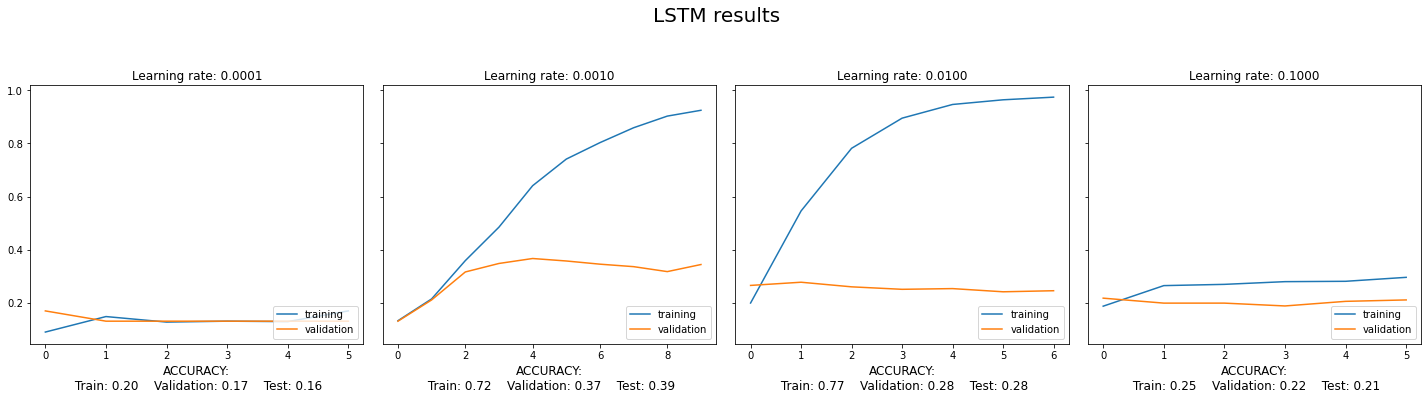

In [0]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True, tight_layout=True)
plt.suptitle("LSTM results\n\n", va='baseline', fontsize=20)
for i, (lr, res) in enumerate(rnn_results.items()):
    hist = res['hist']
    ax[i].set_title(f"Learning rate: {res['learning_rate']:.4f}", fontsize=12)
    ax[i].plot(hist['accuracy'], label='training')
    ax[i].plot(hist['val_accuracy'], label='validation')
    ax[i].set_xlabel(
        f"ACCURACY:\n Train: {res['train_accuracy']:.2f}    "
        f"Validation: {res['validation_accuracy']:.2f}    "
        f"Test: {res['test_accuracy']:.2f}\n",
        fontsize=12
    )
    ax[i].legend(loc='lower right')
plt.show()

The results are considerably weaker. Depending on the actual parameters the accuracy on the test set could occasionally be improved by 1-2 %, but no setup allowed the model to reach even the 40 % limit. Also, whether or not we allow the training of the embedding layer does not seem to have much of an effect:

In [0]:
rnn_emb_non_trainable = train_rnn_model(0.001, emb_trainable=False)
print("Accuracies for an LSTM model with non-trainable embedding layer\n"
      f"Train: {rnn_emb_non_trainable['train_accuracy']:.3f}\t"
      f"Dev: {rnn_emb_non_trainable['validation_accuracy']:.3f}\t"
      f"Test: {rnn_emb_non_trainable['test_accuracy']:.3f}")

Accuracies for an LSTM model with non-trainable embedding layer
Train: 0.423	Dev: 0.352	Test: 0.347


**We will inspect the predictions more closely in Milestone 2.2.**

## Milestone 2

### 2.1: BERT

We had initially some trouble in getting BERT working properly, and therefore decided to use two alternative approaches: Keras and PyTorch. Some massive problems remained (highly likely relationg to the order in which libraries are imported) and we settled for stylewise suboptimal decision to download keras-BERT and retating functions as close to deployment as possile.


### 2.1.1: BERT Keras

In [0]:
# MAX_EXAMPLES and INPUT_LENGTH limited to avoid going out of memory
# Maximum number of examples to read
MAX_EXAMPLES = 1500

# Maximum length of input sequence in tokens
INPUT_LENGTH = 250

To avoid out of memory we have to limit the input size to MAX_EXAMPLES.

In [0]:
def truncate_data(data, MAX_EXAMPLES):
  if len(data) > MAX_EXAMPLES: # truncate data if needed to avoid OOM
    print('Note: truncating examples from {} to {}'.format(len(data), MAX_EXAMPLES)) # should take stratified subsample?
    data = data[:MAX_EXAMPLES]
  return(data)

In [10]:
# We use data sets which only have labels that appear in the training data
# All the datas will be truncated if needed

train_ = truncate_data(df_train, MAX_EXAMPLES)
dev_ = truncate_data(df_test, MAX_EXAMPLES)
test_ = truncate_data(df_test, MAX_EXAMPLES)

frames = [train_, dev_, test_]
for d in frames:
  print(d.shape)
#  print(d.head())

Note: truncating examples from 5295 to 1500
(1500, 2)
(1500, 2)
(1500, 2)


In [0]:
train_reg = train_['reg']

test_ = test_[test_['reg'].isin(train_reg.tolist())]
dev_ = dev_[dev_['reg'].isin(train_reg.tolist())] 

Install keras-bert

In [12]:
!pip3 install keras-bert

In [0]:
os.environ['TF_KERAS'] = '1'    # Required to use tensorflow.python.keras with keras-bert

## Download pretrained FinBERT model

Download pretrained TurkuNLP FinBERT from: https://github.com/TurkuNLP/FinBERT and prepare it for use.

In [14]:
!wget -nc http://dl.turkunlp.org/finbert/bert-base-finnish-cased-v1.zip

# Give -n argument so that existing files aren't overwritten 
!unzip -n bert-base-finnish-cased-v1.zip

# Store paths to important files:
bert_vocab_path = 'bert-base-finnish-cased-v1/vocab.txt'
bert_config_path = 'bert-base-finnish-cased-v1/bert_config.json'
bert_checkpoint_path = 'bert-base-finnish-cased-v1/bert_model.ckpt' # suffixes not required for checkpoints

File ‘bert-base-finnish-cased-v1.zip’ already there; not retrieving.

Archive:  bert-base-finnish-cased-v1.zip


In [0]:
model_is_cased = True

We load the BERT vocabulary and model configurations. Vocabulary contains tags and suffixes needed to utilize our own input texts efficeintly.

In [0]:
vocab = []
with open(bert_vocab_path) as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))    # rstrip to remove newline characters
        
with open(bert_config_path) as f:
    config = json.load(f)

Then we create BERT tokenizer. To do so, we'll need a mapping from vocabulary items to their corresponding integer indices. We do this conventionally using enumerate.

In [0]:
# Create mapping from vocabulary items to their indices in the vocabulary
from keras_bert import Tokenizer as BERT_Tokenizer

token_dict = { v: i for i, v in enumerate(vocab) }

tokenizer = BERT_Tokenizer(token_dict, cased=model_is_cased) 

We will train the label encoder with the labels the truncated training data contains.

In [19]:
# training data
label_encoder = LabelEncoder()    # Turns class labels into integers
train_label = train_['reg'].tolist() 

label_encoder.fit(train_label)
Y = label_encoder.transform(train_label) # encoded labels. Y holds the labels the model will learn to predict.

num_labels = len(set(Y)) # Take note of how many unique labels there are in the data

# development data
dev_label = dev_['reg']
y = label_encoder.transform(dev_label)

# test data
test_label = test_['reg'].tolist()
true_labels = label_encoder.transform(test_label)

true_labels 

array([10, 49, 38, ..., 10, 49, 49])

Then we tokenize input data. We keep token indices and segment ids in separate lists and store as numpy arrays. X here is the final vectorized form of the input we'll be providing to the model for training.

In [0]:
def make_model_inputs(text):
  token_indices, segment_ids = [], []
  for text in text:
      # tokenizer.encode() returns a sequence of token indices
      # and a sequence of segment IDs. BERT expects both as input,
      # even if the segments IDs are just all zeros (like here).
      tid, sid = tokenizer.encode(text, max_len=INPUT_LENGTH)
      token_indices.append(tid)
      segment_ids.append(sid)
  inp = [np.array(token_indices), np.array(segment_ids)] # Format input as list of two numpy arrays
  return inp

In [0]:
X = make_model_inputs(train_['text'])
x = make_model_inputs(dev_['text'])
test_inp = make_model_inputs(test_['text'])

Then we load pretrained BERT model

We'll use the keras-bert function load_trained_model_from_checkpoint to load the model from the checkpoint we downloaded earlier.

Explanation for a few parameters from keras-bert documentation:

- training: If training, the whole model will be returned. Otherwise, the MLM [masked language modeling] and NSP [next sentence prediction] parts will be ignored.
- trainable: Whether the model is trainable. The default value is the same with training.

We don't need the masked language modeling or next sentence prediction parts (these are primarily for pretraining), so we'll use training=False but trainable=True.


In [0]:
from keras_bert import load_trained_model_from_checkpoint

pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False, # ignore MLM [masked language modeling] and NSP [next sentence prediction] parts of the model
    trainable = True,
    seq_len = INPUT_LENGTH # define the size of input layer
)

In [23]:
print(pretrained_model.inputs)
print(pretrained_model.outputs)

[<tf.Tensor 'Input-Token:0' shape=(None, 250) dtype=float32>, <tf.Tensor 'Input-Segment:0' shape=(None, 250) dtype=float32>]
[<tf.Tensor 'Encoder-12-FeedForward-Norm/Identity:0' shape=(None, 250, 768) dtype=float32>]


Size of the input layer is as we defined with varaible INPUT_LENGTH. But the size of the output layer (250) does not match our label count. This must be fixed. This will be done y wrapping the pretrained model. We will grasp the model output and plug our own output layer on it.

In [24]:
type(pretrained_model.outputs[0][:,0])
bert_out = pretrained_model.outputs[0][:,0]
type(bert_out)

tensorflow.python.framework.ops.Tensor

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense


bert_out = pretrained_model.outputs[0][:,0]


out = Dense(num_labels, activation='softmax')(bert_out) # by calling the output layer we end up calling all the other layers (the model)
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

print(model.output)

Tensor("dense/Identity:0", shape=(None, 61), dtype=float32)


BERT is pretrained with an Adam optimizer with warmup and regularization using weight decay. We will copy parameters used in the original BERT work and Deep Learning in Human Language Teghnology -course.

We also set some more parameters to make the model work. These parameters have been optimized by exploring different values. We found out, that the most significant parameter for model performance is learning rate.

In [0]:
# search for optimal EPOCHS, LEARNING_RATE and BATCH_SIZE for serious training!
# Number of epochs to train for
EPOCHS = 12                             #16

# Optimizer learning rate
LEARNING_RATE = 0.00002                   #0.01

# Training batch size
BATCH_SIZE = 16                          #8

In [0]:
from keras_bert import calc_train_steps, AdamWarmup

total_steps, warmup_steps = calc_train_steps(
    num_example=len(train_['text']),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

Then we compile and train the model

In [0]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', # encoded labels!
    metrics=['sparse_categorical_accuracy']
)

In [0]:
stop_cb = EarlyStopping(monitor = 'val_sparse_categorical_accuracy', patience=4, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
#mc_cb = ModelCheckpoint(filepath='models/BERT_multiclass.h5', monitor='val_sparse_categorical_accuracy', verbose=0,save_best_only=True, mode='auto')

history = model.fit(
    X,
    Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x, y), 
    callbacks=[stop_cb]
)

In [0]:
# Explore training performance
def plot_history(history):
    plt.plot(history.history['sparse_categorical_accuracy'],label="Training set accuracy")
    plt.plot(history.history['val_sparse_categorical_accuracy'],label="Validation set accuracy")
    plt.legend()
    plt.show()

plot_history(history)

In [0]:
predictions = np.argmax(model.predict(test_inp), axis=1) # np.argmax gives the index which has the highest value e.g. class
predicted_labels = label_encoder.inverse_transform(predictions) # inverse transform numerical labels to text

# Compare predicted labels to true labels
print("Classification accuracy: ", round(accuracy_score(test_label, predicted_labels)*100,1), "percent")

We reached classification accuracy of  64.8 percent

### 2.1.2: BERT PyTorch

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
b_sentences_train = ["[CLS] " + " [SEP] ".join(query.split(' . ')) + " [SEP]" for query in txt_train]
b_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-finnish-cased-v1")
b_tokenized_train = [b_tokenizer.tokenize(sent) for sent in b_sentences_train]

b_sentences_dev = ["[CLS] " + " [SEP] ".join(query.split(' . ')) + " [SEP]" for query in txt_dev]
b_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-finnish-cased-v1")
b_tokenized_dev = [b_tokenizer.tokenize(sent) for sent in b_sentences_dev]

b_sentences_test = ["[CLS] " + " [SEP] ".join(query.split(' . ')) + " [SEP]" for query in txt_test]
b_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-finnish-cased-v1")
b_tokenized_test = [b_tokenizer.tokenize(sent) for sent in b_sentences_test]

In [0]:
b_train_inputs = torch.tensor(pad_sequences(
    [b_tokenizer.convert_tokens_to_ids(txt) for txt in b_tokenized_train],
    maxlen=BERT_MAX_LEN, dtype="long", truncating="post", padding="post"
))
b_train_labels = torch.tensor(train_classes)

b_dev_inputs = torch.tensor(pad_sequences(
    [b_tokenizer.convert_tokens_to_ids(txt) for txt in b_tokenized_dev],
    maxlen=BERT_MAX_LEN, dtype="long", truncating="post", padding="post"
))
b_dev_labels = torch.tensor(dev_classes)

b_test_inputs = torch.tensor(pad_sequences(
    [b_tokenizer.convert_tokens_to_ids(txt) for txt in b_tokenized_test],
    maxlen=BERT_MAX_LEN, dtype="long", truncating="post", padding="post"
))
b_test_labels = torch.tensor(test_classes)

In [0]:
train_data = TensorDataset(b_train_inputs, b_train_labels)
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)

dev_data = TensorDataset(b_dev_inputs, b_dev_labels)
dev_dataloader = DataLoader(dev_data, batch_size=32)

test_data = TensorDataset(b_test_inputs, b_test_labels)
test_dataloader = DataLoader(test_data, batch_size=32)

In [0]:
model = transformers.BertForSequenceClassification.from_pretrained(
    "bert-base-finnish-cased-v1",
    #config=transformers.BertConfig.from_json_file(str(bert_config_path)),
    num_labels=len(set(train_classes))
) 
model.eval()
if torch.cuda.is_available():
    model = model.cuda()

### 2.2: Error analysis

# Milestone 3.1: Bert (multi-LABEL)

For milestone 3 we will train two multi-label classifiers, one using non-deep contextual representations, the other using Bert. In this setting, each label is assigned independently.

According to the task "each label is assigned independently". We interpreted this to mean, that high level and sublevel labels have no connection and did not explore possible (and presumable) connections.
However, we skimmed how to improve multilabel classification. According to [scikit-multilane] (http: //scikit. ml/labelrelations.html): "Multi-label classification tends to have problems with overfitting and underfitting classifiers when the label space is large, especially in problem transformation approaches. A well known approach to remedy this is to split the problem into subproblems with smaller label subsets to improve the generalization quality."
In our case we could improve the classification by training the separate models for high leve and sublevel registers, since the labels are not independent.

Besides of this a priori knowledge relations between classes could be explored by scikit-multilearn tools.

Data preparation for milestone 3

Since we do multi label classification we are dealing with pure highlevel and sublevel registers instead of combinations. This means we have significantly less unique labels (for example 'NA OP' becomes 'NA' and 'OP') and we have to prepare the data differently from the previous milestones.

For convenience we manipulate a combined data set, where column 'data' holds the information, to which original dataset each row belongs to We will separate all the registers and one hot encode them.

In [0]:
# prepare combined data set for data manipulation

df_train['data'] = 'train'
df_dev_full['data'] = 'dev'
df_test_full['data'] = 'test'

frames = [df_train, df_dev_full, df_test_full]
df = pd.concat(frames).reset_index(drop=True) # get rid of the old indexes # this data used for milestone 3
df = df.rename(columns={"reg": "label"}) # note here a technical detail: column names have been changed 

In [0]:
# Custom function to separate all the labels for one hot encoding
def from_registers(col):
  lst = col.tolist() # column to list
  registers = [[]] # list of lists, as long as the original column
  idx = 0
  for element in lst:    # NA OP
      parts = element.split(' ') # NA #OP
      for i in parts: 
        if i == '': # omit empty strings
          continue
        registers[idx].append(i) # append to list in list
      if len(lst)-1 > idx : # if we have more labels to separate
        idx = idx+1 
        registers.insert(idx, []) # add new empty list to list
  return registers

In [0]:
print(df.shape)
all_regs=from_registers(df['label']) # use custom made function to list the registers
df['regs'] = all_regs

(7564, 3)


Next we will turn those listed registers (column 'regs') to one hot encodings with sklearn MultiLabelBinarizer.

In [0]:
mlb = MultiLabelBinarizer()
dummies = pd.DataFrame(mlb.fit_transform(df['regs']), columns=mlb.classes_, index=df.index)
# join the dummies to original data frame
df = pd.concat([df, dummies], axis=1)
df.head()

,label,text,data,regs,AV,CB,CM,DF,DP,DS,DT,EB,EN,FA,FC,FS,HA,HI,IB,ID,IG,IN,IP,IT,JD,LT,LY,MT,NA,NE,OA,OB,OP,OS,PB,PO,QA,RA,RE,RP,RS,RV,SL,SP,SR,TB
0,CB NA,lauantai Lauantai oli taas mukavan kylmä päiv...,train,"[CB, NA]",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,DT IN,"Aurinkolämmöllä tarkoitetaan järjestelmää , j...",train,"[DT, IN]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,PB NA,Sivut torstai 14. kesäkuuta 2012 Vaihde vapaa...,train,"[PB, NA]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,HI,Valitse kieli : Hae rahoitusta EEP-rahoitusta...,train,[HI],0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,PB NA,"Friday , 13 May 2011 Näin aika kuluu Vanhoja ...",train,"[PB, NA]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# separate train, test and dev datas from one hot encoded combined dataset

train = df[df['data'] == 'train'] 
test = df[df['data'] == 'test'] 
dev = df[df['data'] == 'dev']

# separate X (features) and Y (labels) for training data and x and y for development data

# train
X_ = train['text'] # features
Y_ = train.drop(['regs', 'label','text', 'data'], axis=1) # labels

# dev
x_ = dev['text']
y_ = dev.drop(['regs', 'label','text', 'data'], axis=1)

# test
test_feats_ = test['text']
true_labels_ = test.drop(['regs', 'label','text', 'data'], axis=1) # true labels (one-hot encoded) for testing the model predictions
true_regs_ = test['regs']

## 3.1.1 Classifier 1: Suppor Vector Machine

Now we prepare the first classifier, Linear support vector machine (SVM).

To do multilabel classification we wrap the SVM with [MultiOutputClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier).


For this milestone we followed [scikit tutorial](https://https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) and this [tutorial](https://www.datatechnotes.com/2020/03/multi-output-classification-with-multioutputclassifier.html).

In [0]:
# form feature matrixes
vectorizer = CountVectorizer(max_features = 20000, ngram_range = (1,1)) 

train_feature_matrix = vectorizer.fit_transform(X_)
dev_feature_matrix = vectorizer.transform(x_)
test_feature_matrix = vectorizer.transform(test_feats_)

# Scale input data for SVM
scaler = StandardScaler(with_mean=False)

train_fm = scaler.fit_transform(train_feature_matrix)
dev_fm = scaler.transform(dev_feature_matrix)
test_fm = scaler.transform(test_feature_matrix)

In [0]:
labels = Y_.columns.values.tolist() # labels/registers

estimator = SGDClassifier(random_state=42, alpha=0.0001, max_iter=40, early_stopping=True)

SGDC_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(estimator))
            ])

SGDC_cnfs = []

for category in labels:
    print('... Processing {}'.format(category))
    # train the model
    SGDC_pipeline.fit(train_feature_matrix, Y_[category])
    # compute test accuracy
    prediction = SGDC_pipeline.predict(test_fm)
    print('Test accuracy is {}'.format(accuracy_score(true_labels_[category], prediction)))
    cnf = confusion_matrix(true_labels_[reg], prediction)
    SGDC_cnfs.append(cnf)

print("Confusion matrices saved")

... Processing AV
Test accuracy is 0.9689358889623265
... Processing CB
Test accuracy is 0.650363516192994
... Processing CM
Test accuracy is 0.8182419035029742
... Processing DF
Test accuracy is 0.9187045604758758
... Processing DP
Test accuracy is 0.767349636483807
... Processing DS
Test accuracy is 0.7547918043621943
... Processing DT
Test accuracy is 0.6483807005948447
... Processing EB
Test accuracy is 0.82088565763384
... Processing EN
Test accuracy is 0.8393919365499009
... Processing FA
Test accuracy is 0.7501652346331791
... Processing FC
Test accuracy is 0.8830138797091871
... Processing FS
Test accuracy is 0.9272967614011897
... Processing HA
Test accuracy is 0.8175809649702578
... Processing HI
Test accuracy is 0.33972240581625907
... Processing IB
Test accuracy is 0.7746199603436881
... Processing ID
Test accuracy is 0.9101123595505618
... Processing IG
Test accuracy is 0.8083278255122274
... Processing IN
Test accuracy is 0.8519497686715135
... Processing IP
Test accuracy

/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


Abowe we have the label wise accuracies we will analyze the results at chapter 3.2.

## 3.1.2 Classifier 2: Bert (multi-LABEL)

First we repeat some data preparation steps taken with BERT in chapter 2 but this time for the one hot encoded data.

In [0]:
# MAX_EXAMPLES and INPUT_LENGTH limited to avoid going out of memory
# Maximum number of examples to read 
# Here we acknowledge, that stratified sample would be preferable to keep the original label distribution
MAX_EXAMPLES = 1500

# Maximum length of input sequence in tokens
INPUT_LENGTH = 250

In [0]:
# To avoid OOM, truncate one hot encoded data

train = truncate_data(train, MAX_EXAMPLES)
dev = truncate_data(dev, MAX_EXAMPLES)
test = truncate_data(test, MAX_EXAMPLES)

frames = [train, dev, test]
for d in frames:
  print(d.shape)

Note: truncating examples from 5295 to 1500
Note: truncating examples from 1513 to 1500
(1500, 46)
(756, 46)
(1500, 46)


In [0]:
# remember, INPUT_LENGTH is a parameter for make_model_inputs -function. 
# We also use BERT tokenizer here.

X = make_model_inputs(train['text'])
x = make_model_inputs(dev['text'])
test_inp = make_model_inputs(test['text'])

print(X[0].shape)
print(x[0].shape)
print(test_inp[0].shape)

(1500, 250)
(756, 250)
(1500, 250)


Extract one hot label encodings from the truncated data

In [0]:
# train
Y = train.drop(['regs', 'label','text', 'data'], axis=1)

# dev
y = dev.drop(['regs','label','text', 'data'], axis=1)

# test
true_labels = test.drop(['regs', 'label','text', 'data'], axis=1).reset_index(drop=True) # these are used for evaluating model predictions
true_regs = test['regs'].reset_index(drop=True)

Now the data is prepared for multilabel BERT. We will initialize the hyperparameters, set up the optimizer utilizing them.

In [0]:
# search for optimal EPOCHS, LEARNING_RATE and BATCH_SIZE for serious training!
# Number of epochs to train for
EPOCHS = 30

# Optimizer learning rate
LEARNING_RATE = 0.00001

# Training batch size
BATCH_SIZE = 4

In [0]:
# Set up Adam optimizer for BERT justa as in milestone 2 but with multilabel BERT hyperparameters

total_steps, warmup_steps = calc_train_steps(
    num_example=len(train['text']),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

Again we will wrap the model. We reload the pretrained model with multilabel BERT hyperparameters.

In [0]:
pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False, # ignore MLM [masked language modeling] and NSP [next sentence prediction] parts of the model
    trainable = True,
    seq_len = INPUT_LENGTH # define the size of input layer
)

bert_out = pretrained_model.outputs[0][:,0]

In multi-label classification instead of softmax() we use sigmoid() activation to get the probabilities for each label separatedly. 

For testing choosing the metrics and loss we followed these tutorials and guides [1](https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d), [2](https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/) and [3](https://https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede). 

In [0]:
num_labels = len(mlb.classes_) # size of the output layer

out = Dense(num_labels, activation='sigmoid')(bert_out) # by calling the output layer we end up calling all the other layers (the model)
model = Model(                                          # sigmoid gives us independent probabilities for each class 
    inputs=pretrained_model.inputs,
    outputs=[out]
)

# Now size of the last layer matches the number of the labels and activation (sigmoid) our multilabel purposes
model.output

<tf.Tensor 'dense_2/Identity:0' shape=(None, 42) dtype=float32>

In [0]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy', # one hot encoded labels!
    metrics=['categorical_accuracy']
)

As a loss function we use the binary_crossentropy instead of categorical_crossentropy loss. This is because we want to penalize each output node independently. Categorical crossentropy was also trialed but it resulted in significantly worse results than binary crossentropy (Classification accuracy:  17.7 percent with lr 0.00001 and batch size 16). Hamming loss might also have been a suitable candidate, but it does not have Keras implementation at the moment.

In [0]:
stop_cb = EarlyStopping(monitor = 'val_categorical_accuracy', patience= 8, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
mc_cb = ModelCheckpoint(filepath='models/BERT_multilabel.h5', monitor='val_categorical_accuracy', verbose=0,save_best_only=True, mode='auto')

history = model.fit(
    X,
    Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x, y),
    callbacks=[stop_cb]
)

Epoch 1/30
 10/375 [..............................] - ETA: 1:10:53 - loss: 0.8846 - categorical_accuracy: 0.0000e+00

KeyboardInterrupt: ignored

Inspect the training process.

In [0]:
def plot_history(history):
    plt.plot(history.history['categorical_accuracy'],label="Training set accuracy")
    plt.plot(history.history['val_categorical_accuracy'],label="Validation set accuracy")
    plt.legend()
    plt.show()

plot_history(history)

Since training accuracy is only 60% it seems the model can't fully utilize training data. Also BATCH_SIZEs 8 and 16 were tried but best results were gained with batch size 4. 

Accuracy as a metrics is problematic in multilabel classification. And in our case the data is highly biased: Most of the true occurrences fall in a couple of categories and we have many labels with only a few items belonging to them. Thus predicting for an input text NOT to belong to a certain class improves accuracy. We take a closer look at the model performance in chapter 3.2.

Activation function could also be optimized. By creating a custom made activation function we could shift and optimize the classification threshold of 50% (default value of sigmoid activation). In the other hand this would lead in favoring some labels over the others, which might not be desireable.

Now we will move on and predict: For each input we gain independet probabilities for belonging to each of the labels

In [0]:
predictions = model.predict(test_inp, batch_size = BATCH_SIZE)
# Since we do multiclass, sum of probabilities is over 1.
print(predictions) 
print(sum(predictions[0]))

We will transform predictions to one hot encodings with sigmoid threshold, 50%. This means we select those labels the model predicts with 50% or higher probability.

In [0]:
preds = (predictions >= 0.50).astype(np.uint8) 
print("Predictions are binary sequences:\n", preds[0]) 

predicted_labels = mlb.inverse_transform(preds) # inverse transform gives the registers
print("Inverse transform gives the predicted register name(s):\n" ,predicted_labels[0])

In [0]:
# Now we will utilize scikit-multilearn library and create confusion matrices for all the labels

cnfs = multilabel_confusion_matrix(true_labels, preds)
cnfs.shape # object contains cnf matrix for each label

# Milestone 3.2: Model comparison

Now we will compare the results of the two multilabel classifiers. We will analyze the predictions in terms of label-specific differences. For this purpose use the confusion matrices generated for the both predictions.

We loop over all the labels and plot binary confusion matrices of the both models side by side. Label specific model evaluation metrics will also be printed.

In the confusion matrices we hope to see high numbers on the main diagonal: In such a case the model has predicted well for the instances to belong or not to belong to the relevant class.

By taking a closer look at the matrices and the performance metrics we can see, how highly accuracy and true positive rate correlate from label to label. Predicting 0 (not belonging to a class) has been an encouraged strategy for both of our classifiers since accuracy has been the metrics. Since each text truly belongs only to a few classes, the probability of not belonging to most of them is high but for the classifiers this implies bad performance.

Our SGDC seems to be eager to falsely predict the labels even in cases where the label does not belong to. In other words, false positive rate is high from label to label. But also recall (proportion of true positive labels found) is higher than for BERT.

To further try to improve the multilabel BERT we also trained it having recall as metrics. This anyhow did not improve the model performance.

Since BERT is trained with less training data (1500 instances compared to over 5000) we concentrate the model comparison to labels which appeared in BERT training data close to or over 200 times. These were OS, IN, MT, NE and NA, Na being single label appearing more over than 500 times in the BERT training data. In all these labels BERT has rather high precision and recall, while SGDC keeps producing false positives.

Thus we can state, that BERT performs better in multilabel classification. The model would highly benefit from larger training data but because of the memory restrictions we could not afford exceeding the set limit of 1500 training samples.

In [0]:
# for the plot and analysis code from 
# https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap
# was utilized

idx = 0
for label in mlb.classes_:

  # Set up pic frame: two subplots
  plt.subplots_adjust(wspace=0.8, hspace=0.6)
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
  ax1, ax2 = axes
  label = mlb.classes_[idx]

  # BERT confusion matrix:
  matrix = cnfs[idx]

  FP = matrix[0,1].astype(float) # False positives
  TP = matrix[1,1].astype(float) # True positives
  FN = matrix[1,0].astype(float) # False negatives
  TN = matrix[0,0].astype(float) # True negatives
  
  FPR = round(FP/(FP+TN) * 100, 1) # False positive rate
  TPR = round(TP/(TP+FN) * 100, 1) # True positive rate
  TNR = round(TN/(TN+FP) * 100, 1) # Specificity or true negative rate
  PRE = round(TP/(TP+FP) * 100, 1) # Precision or positive predictive value
  REC = round(TP/(TP+FN) * 100, 1) # Recall
  ACC = round((TP+TN)/(TP+FP+FN+TN) * 100, 1) # Overall accuracy
  NPV = round(TN/(TN+FN) * 100, 1) # Negative predictive value
  FNR = round(FN/(TP+FN) * 100, 1) # False negative rate
  FDR = round(FP/(TP+FP) * 100, 1) # False discovery rate

  for i in range(2):
    for j in range(2):
        c = matrix[j,i]
        ax1.text(i, j, str(c), va='center', ha='center')

  im1 = ax1.matshow(matrix, cmap=plt.cm.Blues)

  ax1.set_title("\n BERT performance for label \"{}\" \n True positive rate {}\n False positive rate {}\n True negative rate {}\n False negative rate {}\n Precision {}\n Recall {}\n False discovery rate {}\n False negative rate {}\n Accuracy {}\n ". format(label, TPR, FPR, TNR, FNR, PRE, REC, FDR, FNR, ACC), fontsize=16)
  
  # Second matrix (SGDC)
  matrix = SGDC_cnfs[idx]

  FP = matrix[0,1].astype(float) # False positives
  TP = matrix[1,1].astype(float) # True positives
  FN = matrix[1,0].astype(float) # False negatives
  TN = matrix[0,0].astype(float) # True negatives
  
  FPR = round(FP/(FP+TN) * 100, 1) # False positive rate
  TPR = round(TP/(TP+FN) * 100, 1) # True positive rate
  TNR = round(TN/(TN+FP) * 100, 1) # Specificity or true negative rate
  FNR = round(FN/(TP+FN) * 100, 1) # False negative rate
  PRE = round(TP/(TP+FP) * 100, 1) # Precision or positive predictive value
  REC = round(TP/(TP+FN) * 100, 1) # Recall: proportion of relevant documents found
  ACC = round((TP+TN)/(TP+FP+FN+TN) * 100, 1) # Overall accuracy
  NPV = round(TN/(TN+FN) * 100, 1) # Negative predictive value
  FDR = round(FP/(TP+FP) * 100, 1) # False discovery rate

  im2 = ax2.matshow(matrix, cmap=plt.cm.Blues)

  ax2.set_title("\n SGDC performance for label \"{}\" \n True positive rate {}\n False positive rate {}\n True negative rate {}\n False negative rate {}\n Precision {}\n Recall {}\n False discovery rate {}\n False negative rate {}\n Accuracy {}\n ". format(label, TPR, FPR, TNR, FNR, PRE, REC, FDR, FNR, ACC), fontsize=16)

  for i in range(2):
    for j in range(2):
      c = matrix[j,i]
      ax2.text(i, j, str(c), va='center', ha='center')

  for axis in axes:
    axis.set_ylabel("True", fontsize = 16)
    axis.set_xlabel("\nPredicted", fontsize = 16)

  idx = idx +1